# Automatically generating object masks with SAM

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [6]:
%pip install torch torchvision torchaudio
%pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Using cached torch-2.0.1-cp38-none-macosx_10_9_x86_64.whl (143.1 MB)
  Using cached torchvision-0.15.2-cp38-cp38-macosx_10_9_x86_64.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 5.3 MB/s eta 0:00:0000:0100:01
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached filelock-3.12.0-py3-none-any.whl (10 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached Pillow-9.5.0-cp38-cp38-macosx_10_10_x86_64.whl (3.4 MB)
  Using cached numpy-1.24.3-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached MarkupSafe-2.1.2-cp38-cp38-macosx_10_9_x86_64.whl (13 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached urllib3-2.0.2-py3-none-any.whl (123 kB)
  Using cached charset_normalizer-3.1.0-cp38-cp38-macosx_10_9_x86_64.whl (123 kB)
  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)
  Using cached mpmath-1.3.0-py3-no

In [1]:
# Import numpy for numerical computation, torch for deep learning, matplotlib for plotting, and OpenCV for image processing
import numpy as np
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
# Define a function to display the segmentations (annotations)
def show_anns(anns):
    # If there are no annotations, return immediately
    if len(anns) == 0:
        return
    
    # Sort the annotations by area in descending order
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    # Set up the plot using Matplotlib
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create an image placeholder with the same shape as the segmentation map
    # The fourth channel is for alpha (transparency)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0  # Set the alpha channel to 0 (transparent)
    
    # For each annotation in the sorted list
    for ann in sorted_anns:
        # Get the segmentation map
        m = ann['segmentation']
        # Create a color mask with random colors and a fixed alpha value
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # Apply the color mask to the segments identified in the image
        img[m] = color_mask
    # Display the image with the colored segmentations
    ax.imshow(img)

## Example image

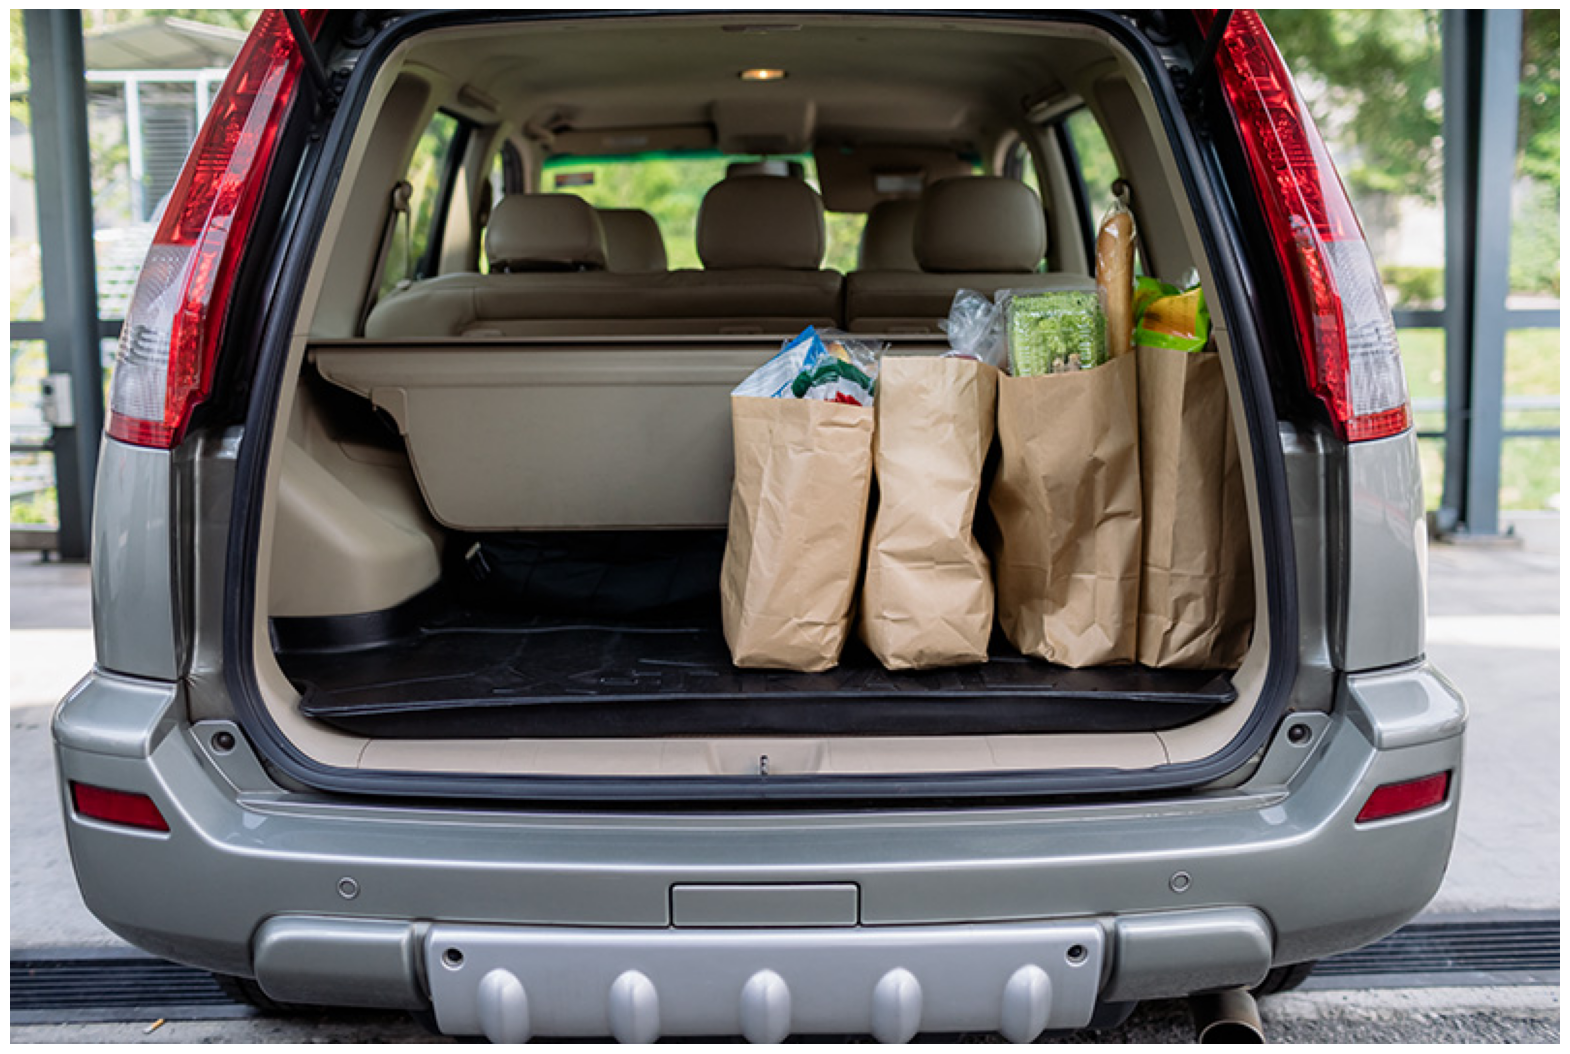

In [23]:
image = cv2.imread('images/groceries.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/adrian/Desktop/cs-projects/segment-anything/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu" 

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [54]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [6]:
print(len(masks))
print(masks[0].keys())

91
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [7]:
print(len(masks))

#Specify the minimum and maximum area value you want to filter by
h, w, _ = image.shape
min_area = 0.02 * h * w

new_dict = []

for i in masks:
    if i['area'] > min_area:
        new_dict.append(i)

print(len(new_dict))

91
14


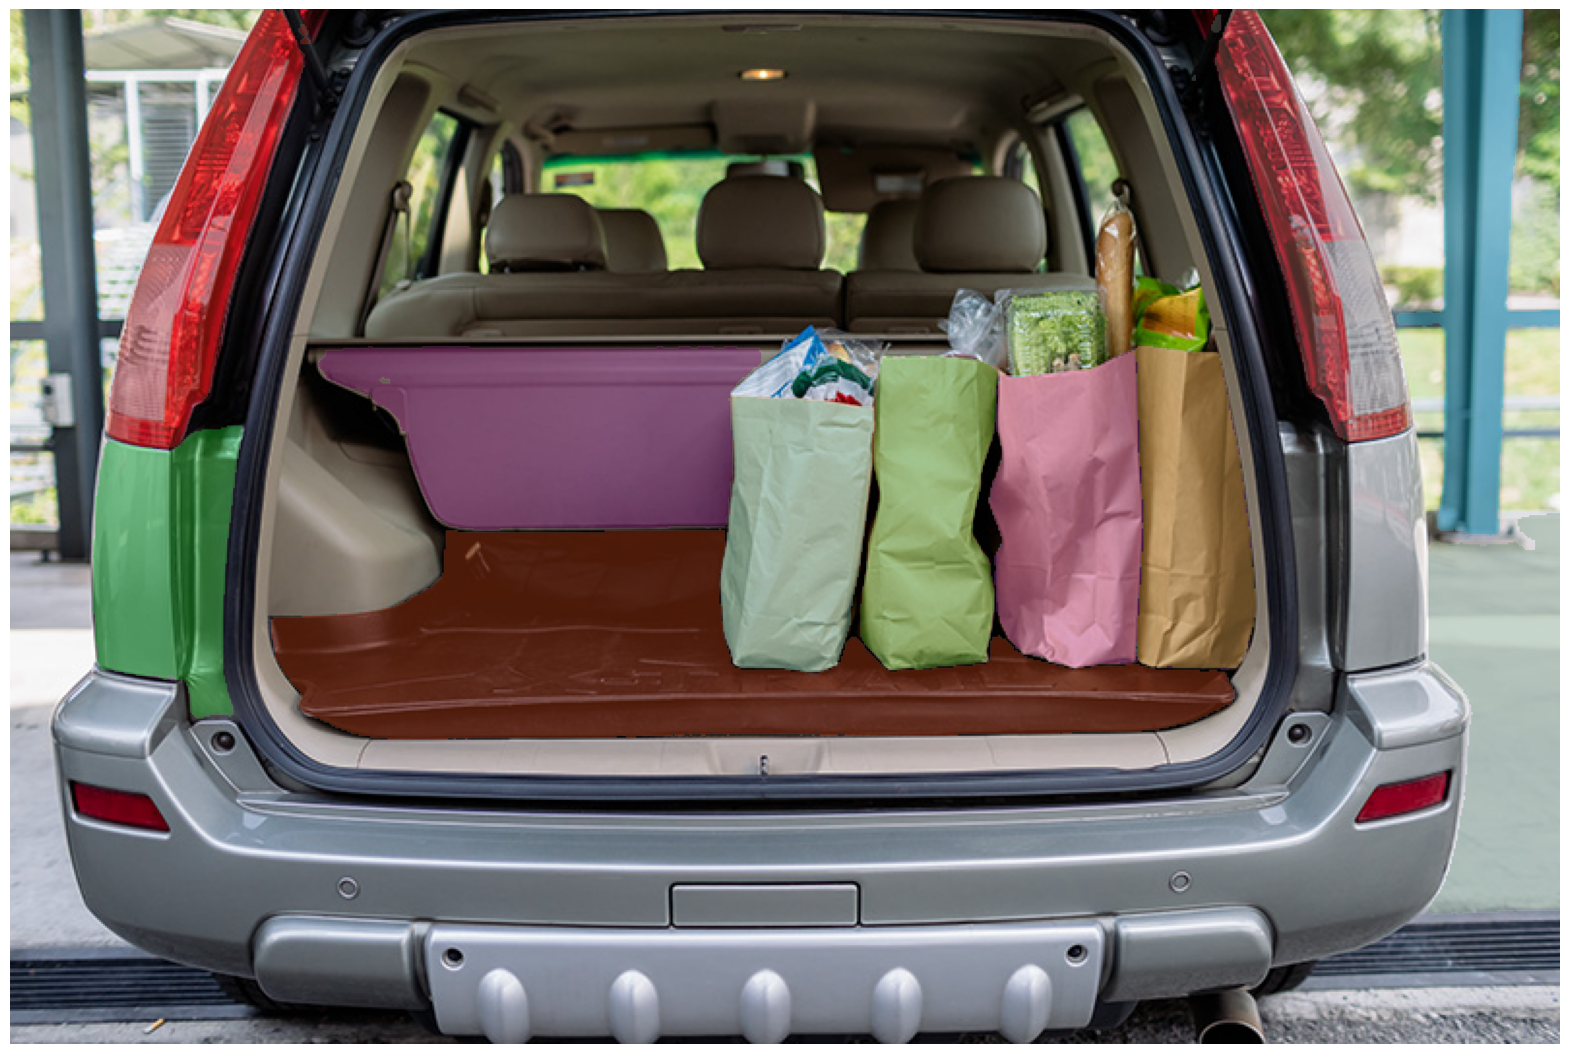

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(new_dict)
plt.axis('off')
plt.show() 

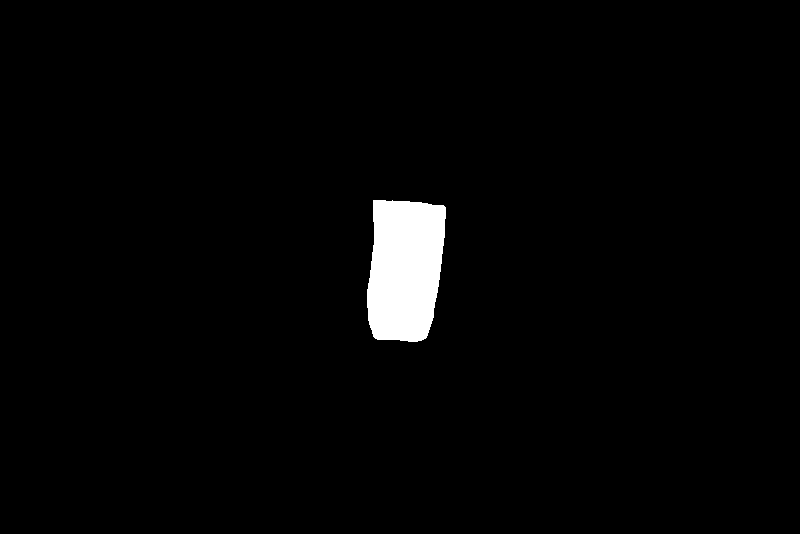

[367, 200, 78, 141]


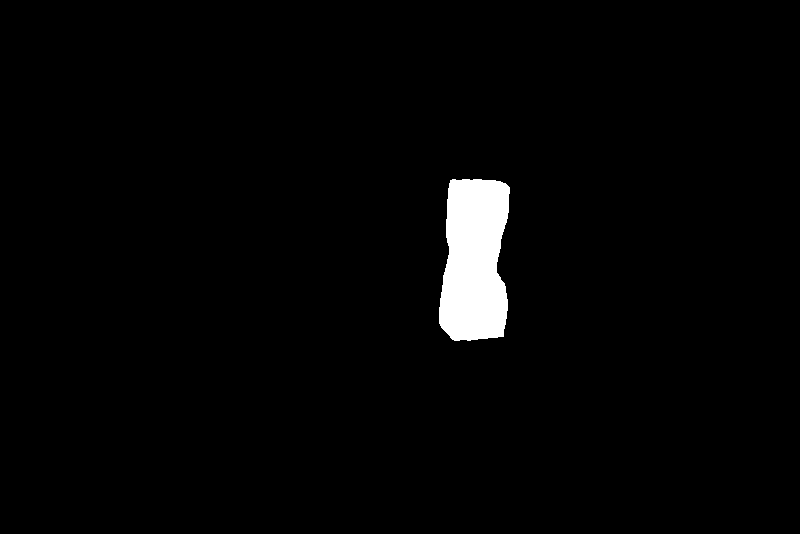

[439, 179, 70, 161]


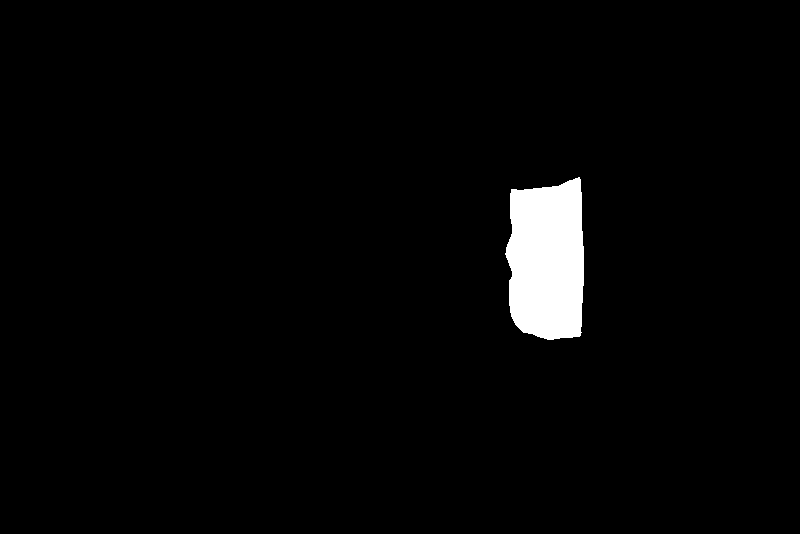

[505, 177, 78, 162]


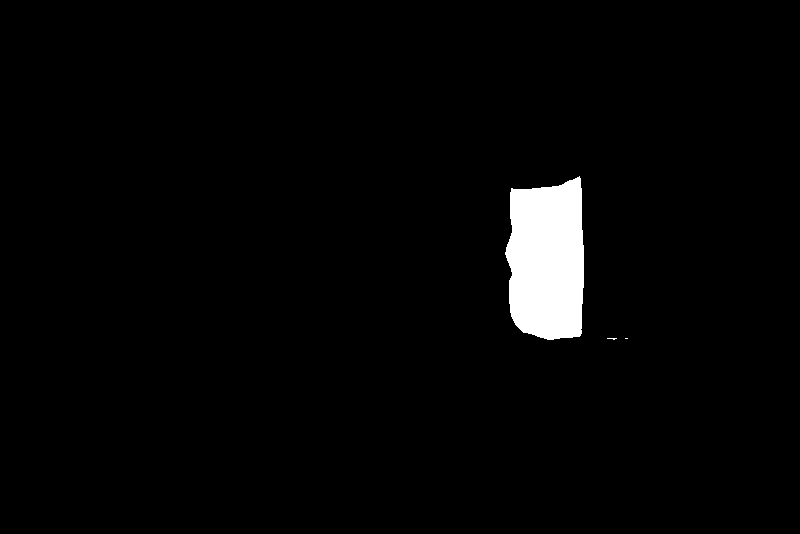

[505, 176, 122, 163]


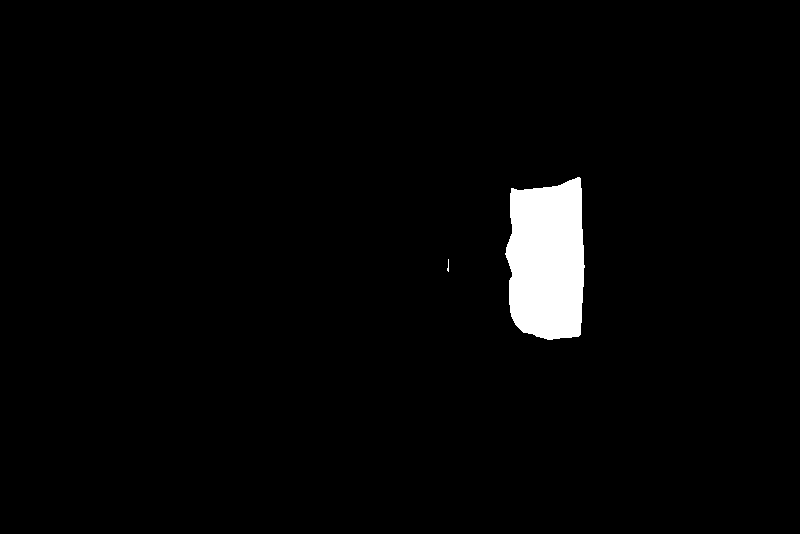

[447, 177, 137, 162]


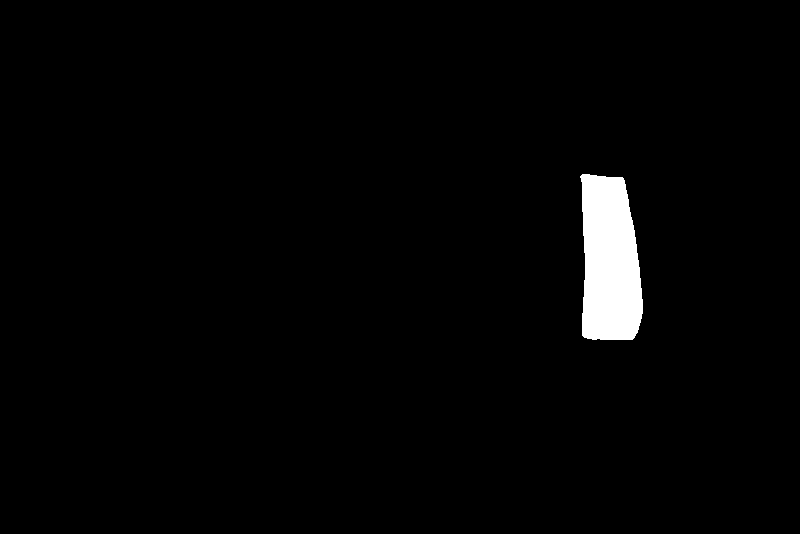

[580, 174, 62, 165]


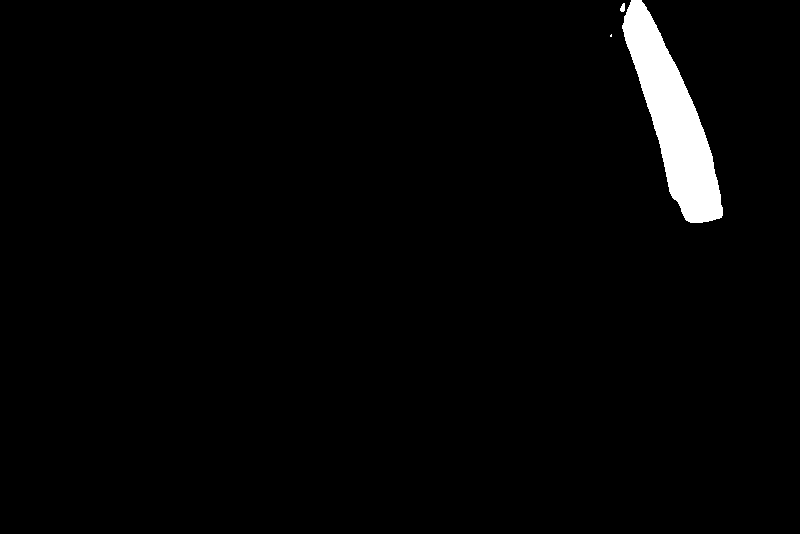

[610, 0, 112, 222]


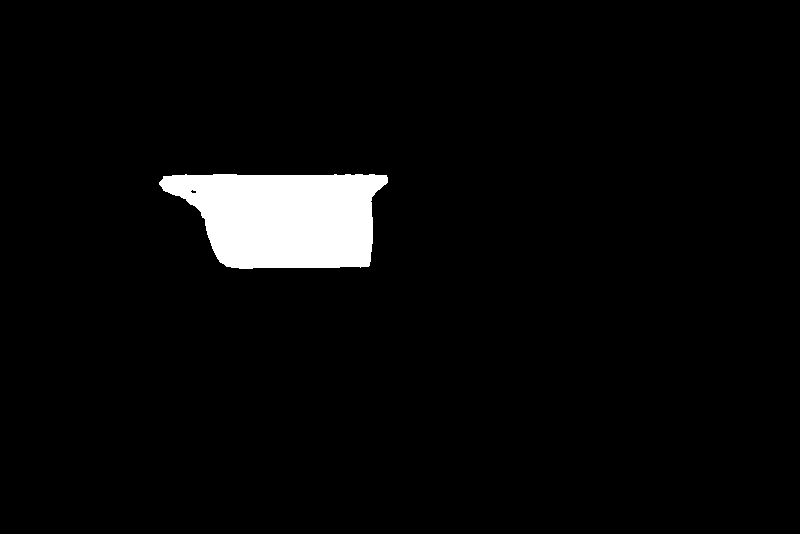

[159, 174, 228, 94]


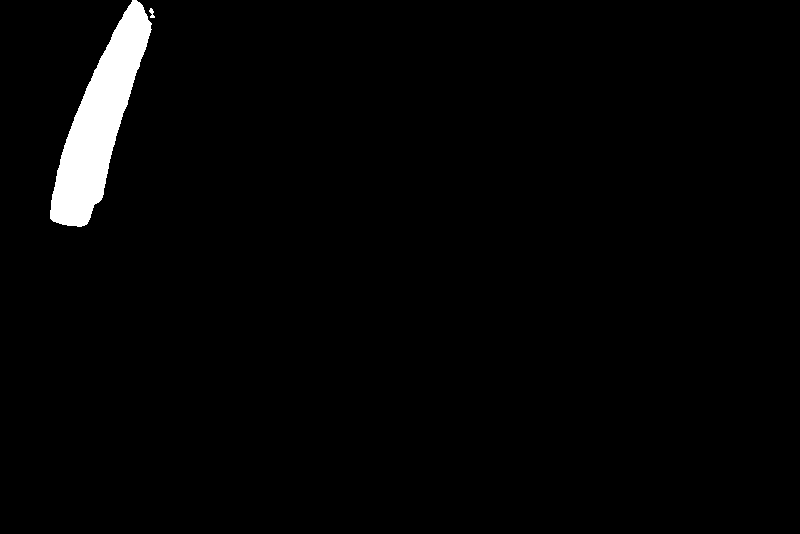

[50, 0, 104, 226]


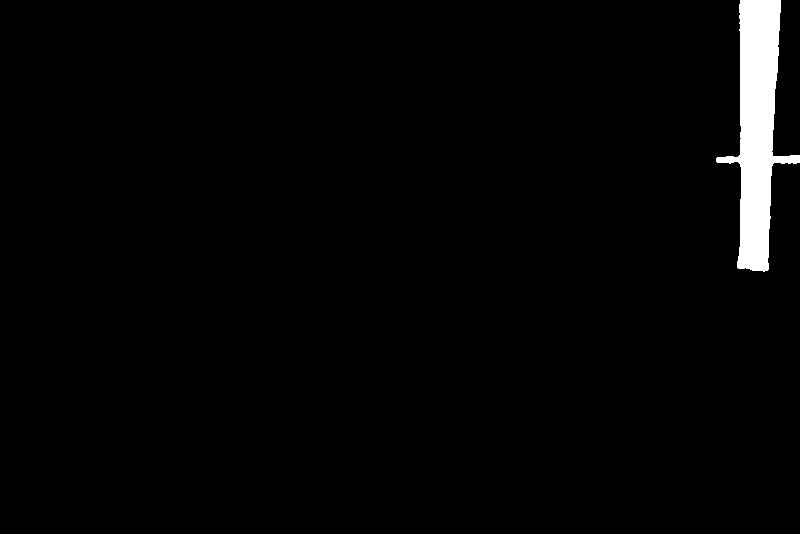

[716, 0, 83, 271]


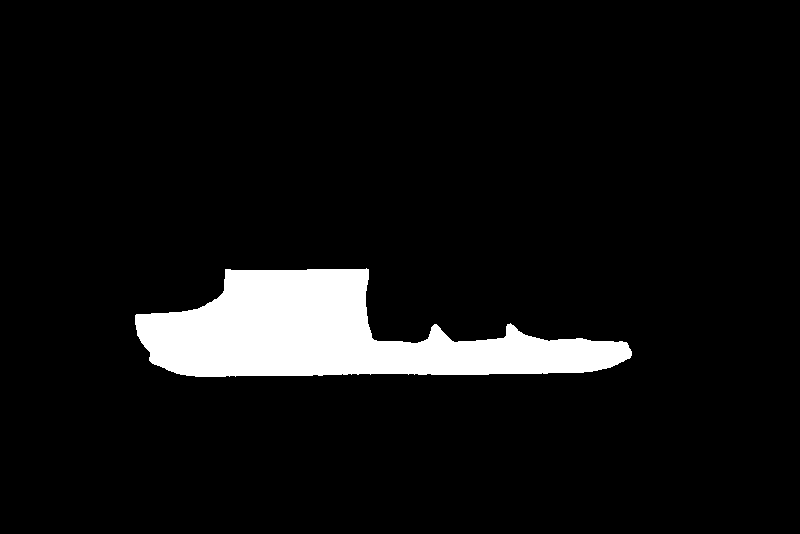

[135, 268, 496, 108]


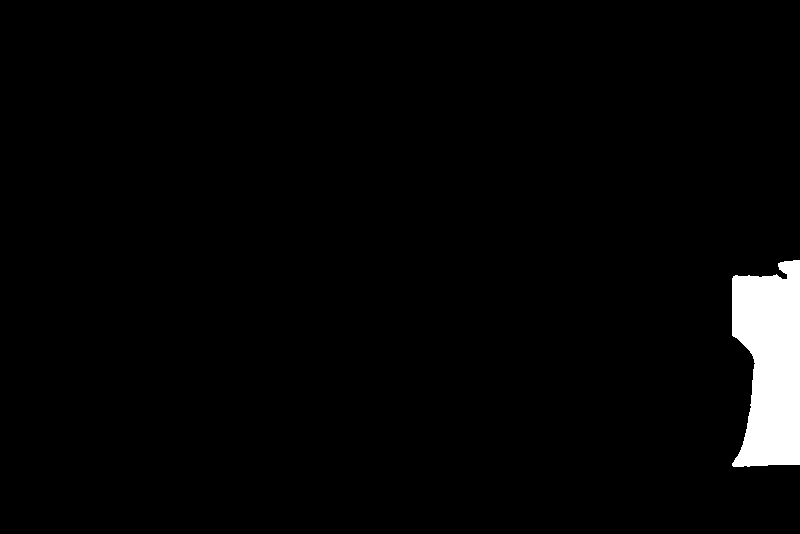

[732, 260, 67, 206]


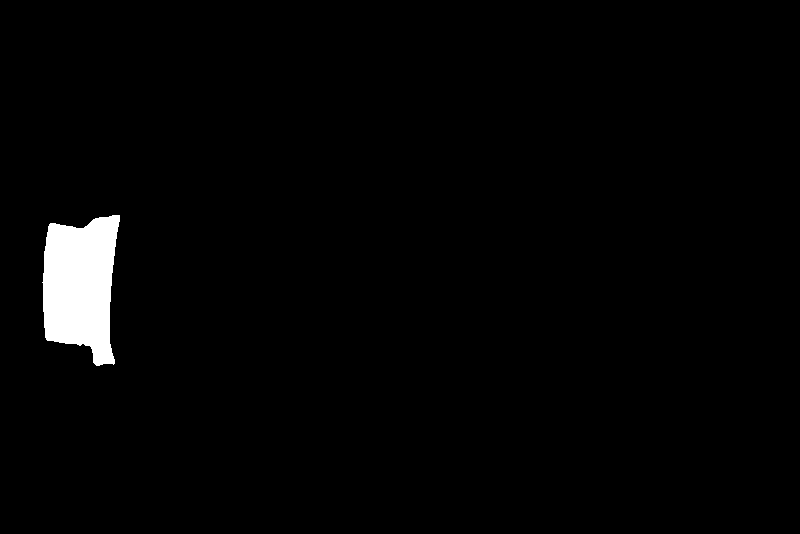

[42, 215, 77, 150]


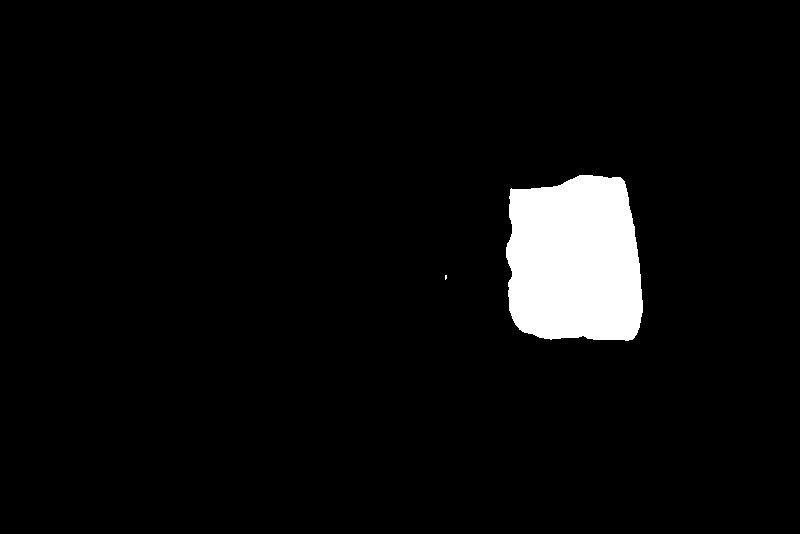

[445, 175, 197, 165]


In [9]:
from PIL import Image
image_tmp = Image.open('/Users/adrian/Desktop/cs-projects/segment-anything/notebooks/images/dog.jpg').convert('RGB')
width, height = image_tmp.size

for i in range(len(new_dict)):
    display(Image.fromarray(new_dict[i]['segmentation']).resize(((width, height))))
    print(new_dict[i]['bbox'])

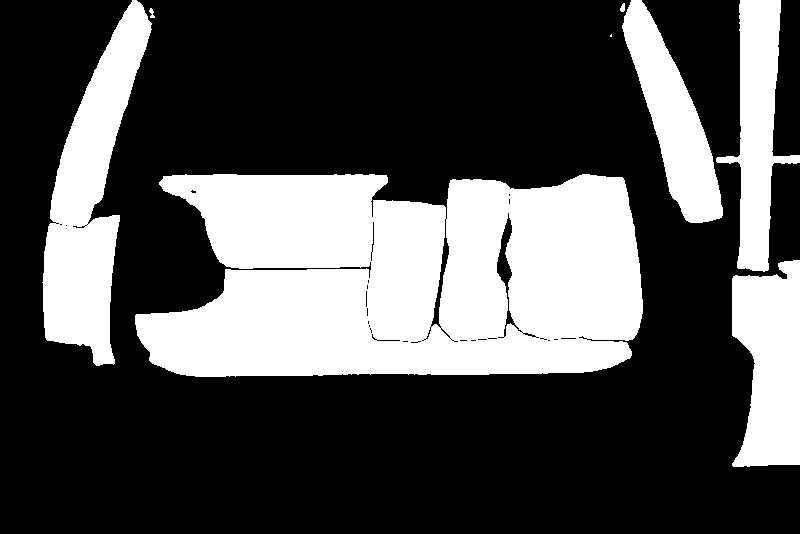

In [10]:
import numpy as np

# Initialize an array to hold the sum of all masks
combined_masks = np.zeros_like(masks[0]['segmentation'])

# Sum all the masks
for mask in new_dict:
    combined_masks += mask['segmentation']

# Normalize to the range 0-255 for image display
combined_masks_normal = (combined_masks / combined_masks.max() * 255).astype(np.uint8)

# Display the combined mask image
display(Image.fromarray(combined_masks_normal).resize((width, height)))


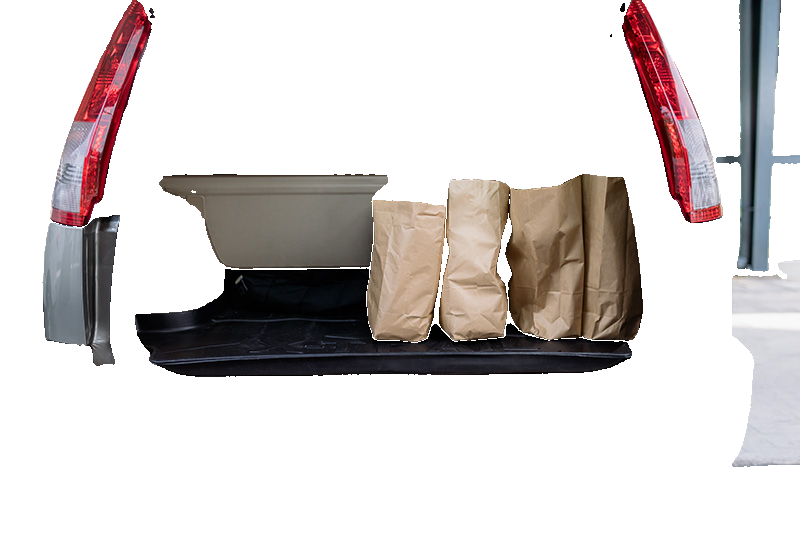

In [11]:
crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

if crop_mode == "wo_bg":
    masked_image = image * combined_masks[:,:,np.newaxis] + (1 - combined_masks[:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
else:
    masked_image = np.array(image)
masked_image = Image.fromarray(masked_image)

display(masked_image.resize((width, height)))

In [18]:
for i in range(len(new_dict)):
    masked_image = image * new_dict[i]['segmentation'][:,:,np.newaxis] + (1 - new_dict[i]['segmentation'][:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
    masked_image = Image.fromarray(masked_image)
    display(masked_image.resize((width, height)))

ValueError: operands could not be broadcast together with shapes (1,3,384,384) (534,800,1) 

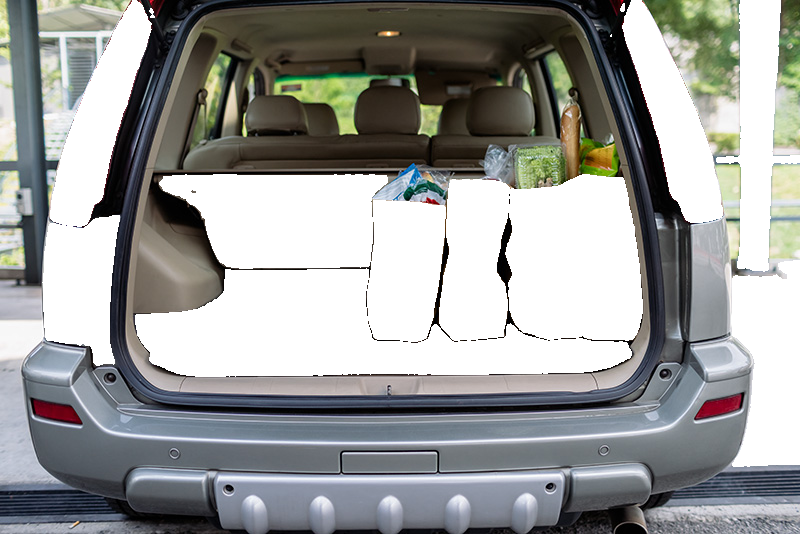

In [13]:
masked_image = image * (1 - combined_masks[:,:,np.newaxis]) + combined_masks[:,:,np.newaxis] * 255
masked_image = np.uint8(masked_image)
masked_image = Image.fromarray(masked_image)
display(masked_image.resize((width, height)))

## Blip-2 Integration
### Setup

In [14]:
%pip install eva-decord
%pip install salesforce-lavis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
from lavis.models import load_model_and_preprocess

/Users/adrian/opt/anaconda3/envs/segment-anything-blip-2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# load sample image
raw_image = Image.open("images/groceries.jpg").convert("RGB")


# loads BLIP caption base model, with finetuned checkpoints on MSCOCO captioning dataset.
# this also loads the associated image processors
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device="cpu")

# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
img = vis_processors["eval"](raw_image).unsqueeze(0).to("cpu")

# generate and prints caption
print(model.generate({"image": img}))

['the back of a car with bags of groceries in the trunk']


In [37]:
capt = [[] for _ in range(len(new_dict))]

model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device="cpu")

for i in range(len(new_dict)):
    masked_image = image * new_dict[i]['segmentation'][:,:,np.newaxis] + (1 - new_dict[i]['segmentation'][:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
    masked_image = Image.fromarray(masked_image)    
    masked_image = vis_processors["eval"](masked_image).unsqueeze(0).to("cpu")

    capt[i].append(new_dict[i]['bbox'])
    capt[i].append(model.generate({"image": masked_image}))

print(capt)

[[[367, 200, 78, 141], ['a brown paper bag on a white background']], [[439, 179, 70, 161], ['a pair of beige shoes on a white background']], [[505, 177, 78, 162], ['a brown paper bag with a white background']], [[505, 176, 122, 163], ['a brown paper bag with a white background']], [[447, 177, 137, 162], ['a piece of brown paper with a white background']], [[580, 174, 62, 165], ['a brown paper bag on a white background']], [[610, 0, 112, 222], ['a red kite is flying in the sky']], [[159, 174, 228, 94], ['a white toilet sitting on top of a white floor']], [[50, 0, 104, 226], ['a red kite is flying in the sky']], [[716, 0, 83, 271], ['a man standing in front of a white wall']], [[135, 268, 496, 108], ['a pair of black shoes on a white background']], [[732, 260, 67, 206], ['a woman in a white dress is holding a cell phone']], [[42, 215, 77, 150], ['a black and white photo of a clock on a wall']], [[445, 175, 197, 165], ['a piece of brown paper on a white background']]]


In [34]:
# full image caption
full_img = vis_processors["eval"](Image.fromarray(image)).unsqueeze(0).to("cpu")

full_img_capt = model.generate({"image": full_img})

print(full_img_capt)

['the back of a car with bags of groceries in the trunk']


In [36]:
crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

bg = image * combined_masks[:,:,np.newaxis] + (1 - combined_masks[:,:,np.newaxis]) * 255
bg = np.uint8(bg)
bg = Image.fromarray(bg)

bg = vis_processors["eval"](bg).unsqueeze(0).to("cpu")

bg_capt = model.generate({"image": bg}) 
print(bg_capt)  

['the back of a car with its trunk open']


In [ ]:
capt
full_img_capt
bg_capt

In [40]:
print(full_img_capt)

['the back of a car with bags of groceries in the trunk']


In [41]:
!pip install bardapi

  Using cached bardapi-0.1.11-py3-none-any.whl (8.8 kB)


In [52]:
# Construct the string
string = f"Here is a list of coordinates of segmented areas of interest in an image and it's corresponding descriptions made by another AI.\n{capt}\n\nNext here we have the description of the entire image\n{full_img_capt}\n\nNext  here we have the description of the background (image with the areas of interest  cropped out)\n{bg_capt}\n\nThe size of the image is {width} x {height} \n\nSome of the description may be contradictory due to imperfections in the captioning AI used. Use your own deductions to determine the most likely description of the image."

print(string)

Here is a list of coordinates of segmented areas of interest in an image and it's corresponding descriptions made by another AI.
[[[367, 200, 78, 141], ['a brown paper bag on a white background']], [[439, 179, 70, 161], ['a pair of beige shoes on a white background']], [[505, 177, 78, 162], ['a brown paper bag with a white background']], [[505, 176, 122, 163], ['a brown paper bag with a white background']], [[447, 177, 137, 162], ['a piece of brown paper with a white background']], [[580, 174, 62, 165], ['a brown paper bag on a white background']], [[610, 0, 112, 222], ['a red kite is flying in the sky']], [[159, 174, 228, 94], ['a white toilet sitting on top of a white floor']], [[50, 0, 104, 226], ['a red kite is flying in the sky']], [[716, 0, 83, 271], ['a man standing in front of a white wall']], [[135, 268, 496, 108], ['a pair of black shoes on a white background']], [[732, 260, 67, 206], ['a woman in a white dress is holding a cell phone']], [[42, 215, 77, 150], ['a black and wh

In [53]:
from bardapi import Bard

token = 'WQi-fkAleKr6TW_5QfWxKCRpeOPdOKdwWky5LVC0BJIduSiQMAsHw5N-AZXKYIX4AapJgw.'
bard = Bard(token=token)

bard.get_answer(string)['content']

'Based on the information you have provided, the most likely description of the image is:\n\n> The back of a car with bags of groceries in the trunk.\n\nThe description of the entire image matches this description, and the description of the background also supports it. The only description that contradicts this is the description of the area of interest that includes the red kite. However, this area of interest is relatively small, and it is possible that the AI simply misidentified the object in this area.\n\nIn addition to the descriptions you have provided, I can also make some deductions based on the size of the image and the fact that the trunk of the car is open. The image is 800 x 534 pixels, which is a relatively large size for an image of a car trunk. This suggests that the image is zoomed in on the trunk, and that it is likely showing a close-up of the bags of groceries. The fact that the trunk is open also suggests that the image was taken while someone was loading or unloa